In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import nibabel as nib
from enigmatoolbox.utils.parcellation import surface_to_parcel, parcel_to_surface

In [2]:
code_dir=Path.cwd()
project_dir=code_dir.parent
thickness_dir=project_dir/"cat_age_thickness"
cat_dir=project_dir.parent/"cat12"
input_dir=project_dir/"input"
output_dir=project_dir/"output/pls_age/"
tmp_dir=project_dir/"tmp"

output_dir.mkdir(exist_ok=True)

In [3]:
atlas_resolution=400

In [10]:
df_data_phenotypical = pd.read_csv(input_dir/'data_phenotypical.csv', index_col="sub_id")

phenotypical_variables = ["base_age", "base_sex", "base_education_isced","cognition_tmt_a", "cognition_tmt_b", 
    "cognition_animal_naming_test", "cognition_word_list_recall", "cognition_mini_mental_state_exam","motor_hand_grip_strength_r_mean","motor_hand_grip_strength_l_mean",
     "motor_time_timed_up_and_go_test", "motor_successful_chair_rising_test", "motor_successful_tandem_test"]

df_data_phenotypical = df_data_phenotypical[phenotypical_variables]

In [12]:
df_data_phenotypical = df_data_phenotypical[df_data_phenotypical.index.isin(df_data_cat.index)]

In [13]:
df_thickness_data_schaefer = pd.read_csv(input_dir/"df_thickness_data_schaefer.csv", delim_whitespace=True, index_col=0)

# Partial least squares

In [19]:
data_predict = pd.DataFrame(df_data_phenotypical).join(df_thickness_data_schaefer)
data_predict.dropna(axis=1, inplace=True, how="all")
data_predict.dropna(axis=0, inplace=True, how="any")
thickness_columns = [col for col in data_predict.columns if col not in df_data_phenotypical.columns]
y = data_predict[df_data_phenotypical.columns]
X = data_predict[thickness_columns]

In [ ]:
from pyls import behavioral_pls
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

bpls = behavioral_pls(X.values, y.values, n_boot=5000, n_perm=5000)

In [40]:
from pyls import save_results
save_results(project_dir/"output/pls_age/pls", bpls)

'/media/marvin/Seagate Expansion Drive/CSI_HCHS/data/2021_petersen_ageing_atrophy_connectomics/output/pls_age/pls.hdf5'

In [15]:
from pyls import load_results
bpls = load_results(project_dir/"output/pls_age/pls.hdf5")

In [16]:
variable_names_styled=["Age", "Sex at birth", "Education","Trail Making Test A", "Trail Making Test B", 
    "Animal Naming Test", "Word List Recall", "Mini Mental State Exam","Hand grip strength right","Hand grip strength left",
     "Timed Up And Go Test", "Chair Rising Test", "Tandem Test"]

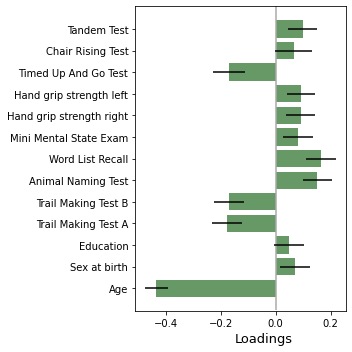

In [20]:
import matplotlib.pyplot as plt
y_loadings = pd.DataFrame({"y_loadings":bpls["y_loadings"][:,0], 
"y_loadings_ci_lower":bpls["bootres"]["y_loadings_ci"][:,0][:,0],
"y_loadings_ci_upper":bpls["bootres"]["y_loadings_ci"][:,0][:,1]},
index=y.columns)
y_loadings["y_loadings_ci_lower_offset"] = np.abs(y_loadings["y_loadings_ci_lower"] - y_loadings["y_loadings"])
y_loadings["y_loadings_ci_upper_offset"] = np.abs(y_loadings["y_loadings_ci_upper"] - y_loadings["y_loadings"])

fig,ax = plt.subplots(1, figsize=(5,5))
ax.vlines(0,ymin=-1,ymax=15, colors='darkgray')
ax.barh(y=y_loadings.index, width=y_loadings.y_loadings, color='#669966',
    xerr=[y_loadings.y_loadings_ci_lower_offset,y_loadings.y_loadings_ci_upper_offset])
variable_names = [col for col in df_data_phenotypical.columns]
plt.yticks(ticks=list(range(len(variable_names_styled))), labels=variable_names_styled, size=10)
plt.xlabel("Loadings",horizontalalignment="right", position=(0.75,0), size=13)

plt.tight_layout()
plt.savefig(output_dir/"barplot_phenotypical_loadings.png", dpi=300)

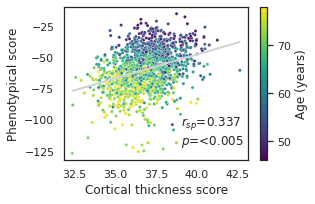

In [43]:
import seaborn as sns
from scipy.stats import spearmanr
scores_correlation = pd.DataFrame({"Cortical thickness score":bpls["x_scores"][:,0],"Phenotypical score":bpls["y_scores"][:,0],"Age":y["base_age"]})
sns.set(rc={'figure.figsize':(4.5,3)},style="white")
ax = sns.scatterplot(x="Cortical thickness score", y="Phenotypical score", data=scores_correlation, 
c=scores_correlation["Age"],alpha=1, s=10, cmap="viridis")

norm = plt.Normalize(scores_correlation["Age"].min(), scores_correlation["Age"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

m, b = np.polyfit(scores_correlation["Cortical thickness score"], scores_correlation["Phenotypical score"], 1)
ax.plot(scores_correlation["Cortical thickness score"], m * scores_correlation["Cortical thickness score"] + b, color="lightgray")

# Add a colorbar
ax.figure.colorbar(sm, location="right", label="Age (years)")

plt.tight_layout()

corr,pval = spearmanr(scores_correlation["Cortical thickness score"], scores_correlation["Phenotypical score"], nan_policy="omit")
if pval < 0.005: pval = "<0.005"
plt.annotate(f'$r_{{sp}}$={corr:0.3} \n$p$={pval}', xy=(39,-120))
plt.savefig(output_dir/"scatterplot_correlation_scores_age.png", dpi=300)

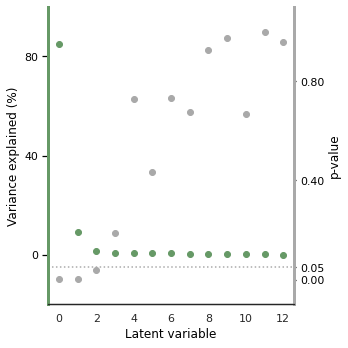

In [22]:
latent_variables_sig = pd.DataFrame({"Explained variance (%)":bpls["varexp"] * 100,"p-value":bpls["permres"]["pvals"]})

fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax_color='#669966'
ax.plot(latent_variables_sig.index, latent_variables_sig["Explained variance (%)"], "o", color=ax_color)
ax.set_xlabel("Latent variable", color="black", size=12)
ax.set_ylabel("Variance explained (%)", color="black", size=12)
ax.tick_params(axis="y", colors="black")
ax.spines["top"].set_visible(False)
ax.set_ylim(-0.1,1)
ax.set_yticks(ax.get_yticks() * 100)
ax.locator_params(axis="y",nbins=4)

ax2_color="darkgray"
ax2.plot(latent_variables_sig.index, latent_variables_sig["p-value"], "o", color=ax2_color)
ax2.set_ylabel("p-value", color="black", size=12)
ax2.spines["right"].set_color(ax2_color)
ax2.spines["right"].set_linewidth(3)
ax2.spines["left"].set_color(ax_color)
ax2.spines["left"].set_linewidth(3)
ax2.tick_params(axis="y", colors="black", size=2)
ax2.spines["top"].set_visible(False)
ax2.set_ylim(-0.1,1.1)
ax2.set_yticks([0.  , 0.4 , 0.8 , 0.05])
ax2.locator_params(axis="y",nbins=4)

plt.axhline(y=0.05, color=ax2_color, linestyle='dotted')

plt.tight_layout()
plt.savefig(f"{output_dir}/explained_variance.png", dpi=300, bbox_inches='tight')


In [ ]:
latent_variables_sig["p-value"]

0     0.000200
1     0.000400
2     0.039992
3     0.188562
4     0.729054
5     0.434513
6     0.733253
7     0.677465
8     0.926415
9     0.972006
10    0.668666
11    0.999800
12    0.956809
Name: p-value, dtype: float64

In [23]:
latent_variables_sig["Explained variance (%)"]

0     85.096707
1      9.171140
2      1.516065
3      0.832268
4      0.689248
5      0.620280
6      0.521711
7      0.443405
8      0.361422
9      0.297952
10     0.199595
11     0.191003
12     0.059203
Name: Explained variance (%), dtype: float64

In [33]:
from enigmatoolbox.datasets import load_fc

_, fc_ctx_labels, _, _ = load_fc(parcellation=f'schaefer_{atlas_resolution}')

In [35]:
sig_bootstrap_ratio = bpls["bootres"]["x_weights_normed"][:,0].copy()
sig_bootstrap_ratio[(sig_bootstrap_ratio<2.58) & (sig_bootstrap_ratio>-2.58)]=np.nan

In [36]:
from enigmatoolbox.plotting import plot_cortical
from enigmatoolbox.utils.parcellation import parcel_to_surface

pls_br_ct_schaefer = pd.DataFrame(bpls["bootres"]["x_weights_normed"][:,0], index=X.columns)
pls_br_ct_schaefer = pd.DataFrame(index=fc_ctx_labels).join(pls_br_ct_schaefer) 
pls_br_ct_schaefer_c69 = parcel_to_surface(pls_br_ct_schaefer, f'schaefer_{atlas_resolution}_conte69')

img = plot_cortical(array_name=parcel_to_surface(pls_br_ct_schaefer.values, f'schaefer_{atlas_resolution}_conte69'), surface_name="conte69", size=(800, 200),
              cmap='Greens', color_bar=True, embed_nb=True, interactive=False, transparent_bg=False, nan_color=(256,256,256,0),
              screenshot=True, filename=f"../output/pls_age/bootstrap_ratio_ct.png")

In [37]:
thickness_data_array=nib.load(thickness_dir/"beta_0002.gii").darrays[0]
thickness_beta=nib.gifti.parse_gifti_fast.read_data_block(darray=thickness_data_array,fname=thickness_dir/"beta_0002.dat", data=None, mmap=False)
thickness_beta_schaefer = surface_to_parcel(thickness_beta, f'schaefer_{atlas_resolution}_conte69')[1:]

In [38]:
meas1 = 'Bootstrap ratio'

meas = {(meas1, r'$\beta$ Age'): [np.squeeze(pls_br_ct_schaefer.values), thickness_beta_schaefer],
}

In [39]:
rvals, pvals, p_and_d, color, color_gradient = perform_spins_single(
    parc_meas1 = np.squeeze(pls_br_ct_schaefer.values), 
    name_meas1 = meas1,
    color_meas1 = '#669966')

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


In [40]:
import matplotlib.pyplot as plt

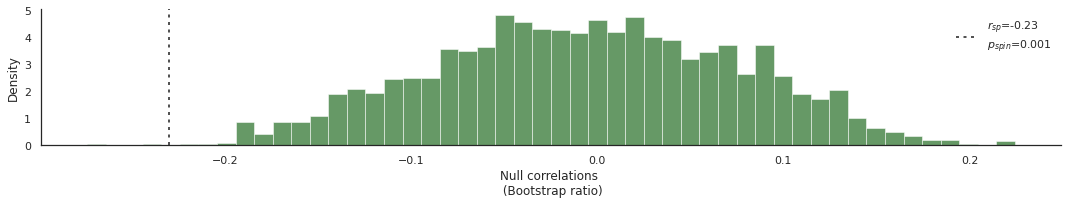

In [41]:
fig = plot_null_distributions(p_and_d, rvals, color)
fig.savefig(output_dir/"thickbeta_bootstrap_ratio_null.png", dpi=300)

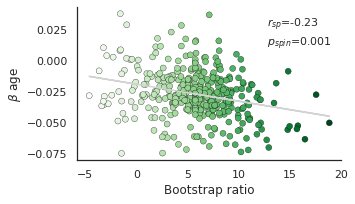

In [45]:
fig, axs = plt.subplots(1, len(meas.items()), figsize=(5, 3))

fn = (meas1,
  '$\\beta$ Age')
dd = meas[fn]

axs.scatter(meas[fn][0], meas[fn][1], c=color_gradient[fn[0]],
    
    label=f'$r_{{sp}}$={rvals[fn[0]]:.2f} \n$p_{{spin}}$={pvals[fn[0]]:.3f}', 
    
    cmap="Greens", edgecolors="black", linewidth=0.3)


fin_idx = np.isfinite(np.array(list(meas[fn][0]))) & np.isfinite(np.array(list(meas[fn][1])))
m, b = np.polyfit(np.array(list(meas[fn][0]))[fin_idx], np.array(list(meas[fn][1]))[fin_idx], 1)

axs.plot(list(meas[fn][0]), m * np.array(list(meas[fn][0])) + b, color="lightgray")

axs.set_xlabel('{}'.format(fn[0].capitalize()))

axs.set_ylabel('{}'.format(fn[1].capitalize()))

axs.spines['top'].set_visible(False)

axs.spines['right'].set_visible(False)

axs.legend(loc=1, frameon=False, markerscale=0)

fig.tight_layout()

plt.show()

fig.savefig(output_dir/"thickbeta_bootstrap_ratio.png", dpi=300)